# 04. Charlotte Shapefile

The shapefile for Department 35-00103 (Charlotte, NC) consists of point geometries instead of polygons. Let's see what we can do with it.

Related post (feat. mindblow meme from Chris):

https://www.kaggle.com/center-for-policing-equity/data-science-for-good/discussion/70085

# Load shapefile

In [1]:
import matplotlib.pyplot as plt
import pytess

from cpe_help import Department, util
from cpe_help.tiger import get_tiger
from shapely.geometry import Polygon

In [2]:
dept = Department('35-00103')
dept.full_name

'35-00103 (Charlotte, NC)'

In [3]:
df = dept.load_external_shapefile()

In [4]:
df.shape

(16, 20)

In [5]:
df.head()

,OBJECTID_1,OBJECTID,NAME,STBLKNO,STDIR,STNAME,STTYPE,SUITE,ADDRESS,X,Y,City,State,Zip,GlobalID,CreationDa,Creator,EditDate,Editor,geometry
0,1,1,Steele Creek Division,2227,None,WESTINGHOUSE,Bv,None,2227 WESTINGHOUSE BV,1419153,507731,Charlotte,NC,28273,db318949-09b5-4fdf-8e1c-0b108372308a,2018-05-21T09:01:35.168Z,CharlotteNC,2018-05-21T09:01:35.168Z,CharlotteNC,POINT (-80.94281565376032 35.12947416386795)
1,2,2,South Division,8050,None,CORPORATE CENTER,DR,100,8050 SUITE CORPORATE CENTER DR SUITE 100,1444638,491395,Charlotte,NC,28226,0d16b5be-f8ae-4497-a5e7-b345804fcd9d,2018-05-21T09:01:35.168Z,CharlotteNC,2018-05-21T09:01:35.168Z,CharlotteNC,POINT (-80.85657216690885 35.0859356696823)
2,3,3,Eastway Division,3505,None,CENTRAL,AV,None,3505 CENTRAL AVE,1466679,538447,Charlotte,NC,28205,36aca867-4da3-4366-941c-dc1d23b955d7,2018-05-21T09:01:35.168Z,CharlotteNC,2018-05-21T09:01:35.168Z,CharlotteNC,POINT (-80.78573476790018 35.21630963209508)
3,4,4,Family Services Division,601,E,5TH,ST,None,601 E 5TH ST,1451582,541409,Charlotte,NC,None,90b69da2-551c-43c0-bc6a-8f2fc6791076,2018-05-21T09:01:35.168Z,CharlotteNC,2018-05-21T09:01:35.168Z,CharlotteNC,POINT (-80.83645647801634 35.22369015519719)
4,5,5,Freedom Division,4150,None,WILKINSON,BV,None,4150 WILKINSON BV,1430149,542795,Charlotte,NC,28208,4a861dcb-ec72-4fb3-9ad2-51f243dfd3a9,2018-05-21T09:01:35.168Z,CharlotteNC,2018-05-21T09:01:35.168Z,CharlotteNC,POINT (-80.9082997144494 35.22638705042786)


# Visualize

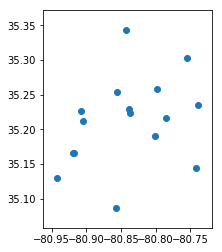

In [6]:
df.plot()

# folium would be really good here

# Load city

In [7]:
dept.state.fips

'37'

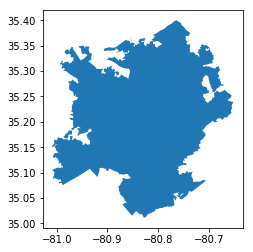

In [8]:
tiger = get_tiger()
places = tiger.load_place_boundaries('37')
city = places[places['NAME'] == dept.city]
city.plot()

# that's Charlotte!

# Visualize city and points

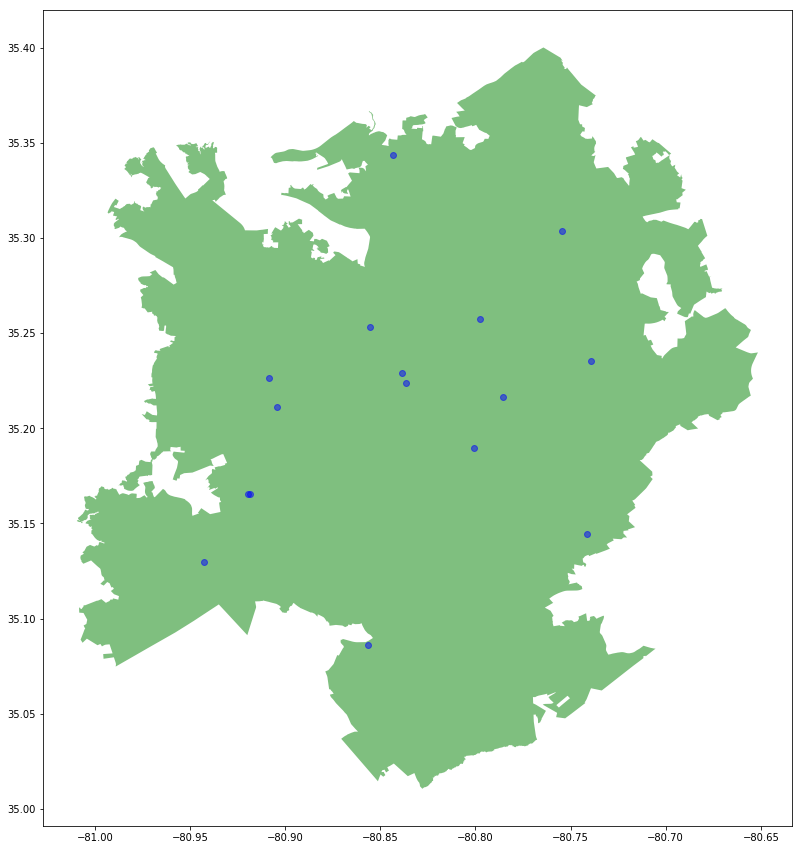

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.set_aspect('equal')

city.plot(ax=ax, color='green', alpha=0.5)
df.plot(ax=ax, color='blue', alpha=0.5)

See that two overlapping points? One of them is an academy. We can remove it.

In [10]:
academy = df[df['NAME'] == 'Academy']
academy

,OBJECTID_1,OBJECTID,NAME,STBLKNO,STDIR,STNAME,STTYPE,SUITE,ADDRESS,X,Y,City,State,Zip,GlobalID,CreationDa,Creator,EditDate,Editor,geometry
10,11,11,Academy,1770,None,SHOPTON,RD,None,1770 SHOPTON RD,1426315,520606,Charlotte,NC,28217,d261144e-c28b-4a15-b4ea-05e8387868ac,2018-05-21T09:01:35.168Z,CharlotteNC,2018-05-21T09:01:35.168Z,CharlotteNC,POINT (-80.91969893099946 35.16522694978815)


In [11]:
df = df[df['NAME'] != 'Academy']

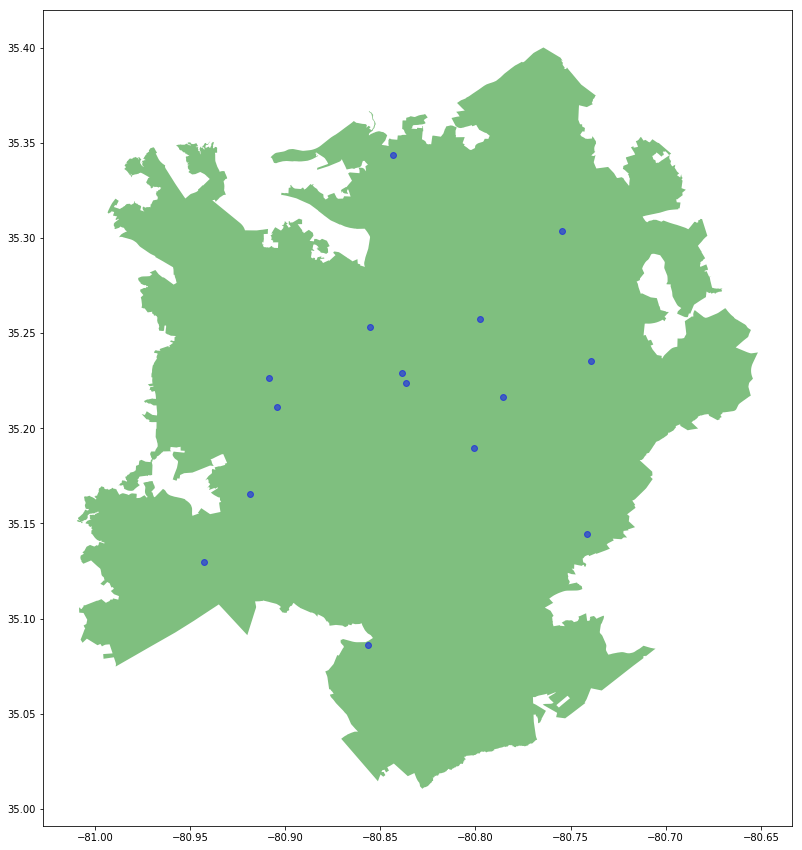

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.set_aspect('equal')

city.plot(ax=ax, color='green', alpha=0.5)
df.plot(ax=ax, color='blue', alpha=0.5)

Okay. Now we can deal with these points. Options:

- Voronoi diagram (bounded by the city)
- Radius around points
- Some way of estabilishing bounds intelligently ...?

# Method 1: Radius around points

In [13]:
# set projection to equal area
proj = util.crs.equal_area_from_geodf(city)
df = df.to_crs(proj)
city = city.to_crs(proj)

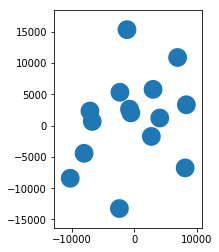

In [14]:
df1 = df.buffer(1500)  # arbitrary measure (1.5km)
df1.plot()

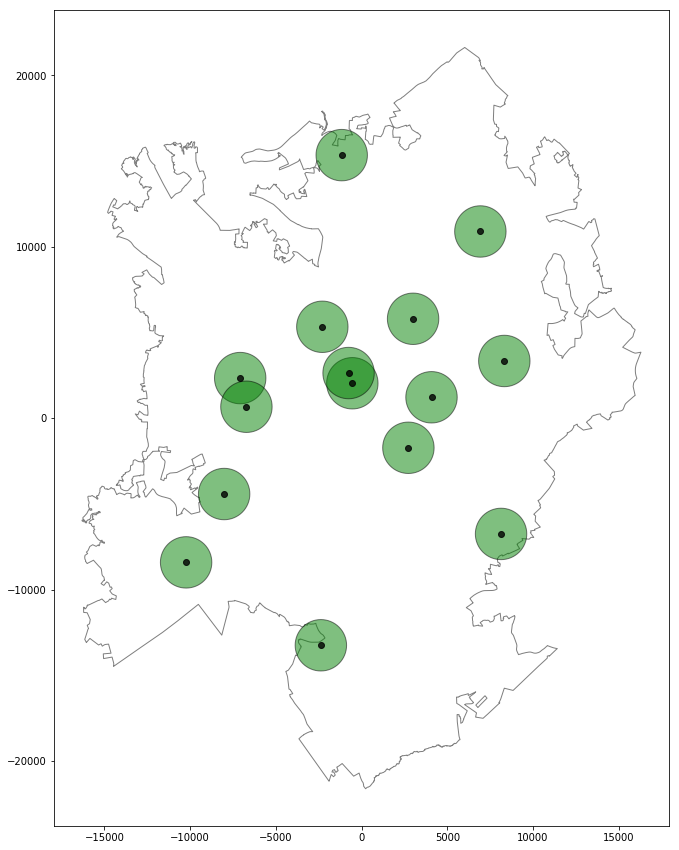

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.set_aspect('equal')

city.plot(ax=ax, color='none', edgecolor='black', alpha=0.5)
df1.plot(ax=ax, color='green', edgecolor='black', alpha=0.5)
df.plot(ax=ax, color='k', alpha=0.8);

Nice! One problem I can see is that the two stations in the middle share a lot of area. And, There are lots of regions of the city not covered by the boundaries. These problems can both be solved by:

# Voronoi Diagrams

Let's use this nice package called [pytess][1].

[1]: https://github.com/karimbahgat/Pytess

In [16]:
df.loc[0, 'geometry'].x

-10233.67171672698

In [17]:
points = [(p.x, p.y) for p in df.geometry]
points[:3]

[(-10233.67171672698, -8413.371819652122),
 (-2374.389084824885, -13249.133749057148),
 (4078.915909330828, 1215.67165757121)]

In [18]:
diagram = pytess.voronoi(points, buffer_percent=400)
polygons = [Polygon(x[1])for x in diagram if x[0] is not None]

df2 = df.copy()
df2.geometry = polygons
df2.geometry = df2.geometry.intersection(city.unary_union)

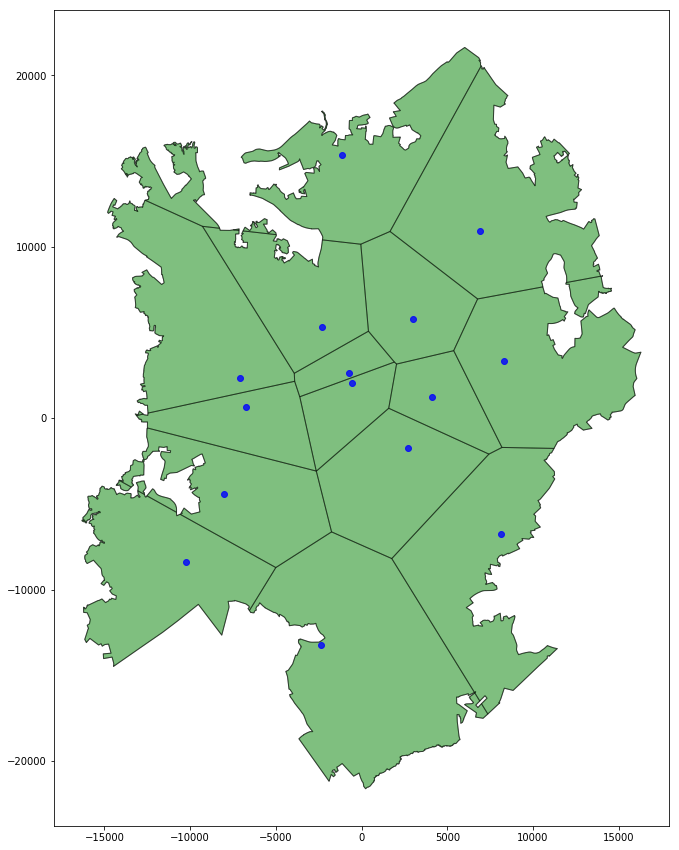

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.set_aspect('equal')

city.plot(ax=ax, color='none', edgecolor='black', alpha=0.5)
df2.plot(ax=ax, color='green', edgecolor='black', alpha=0.5)
df.plot(ax=ax, color='blue', alpha=0.8);

This is beautiful... Could get even more beautiful though if we used the Manhattan Distance (or the real police boundaries). But, let's stick with one of the choices...

# Plot back in EPSG:4269

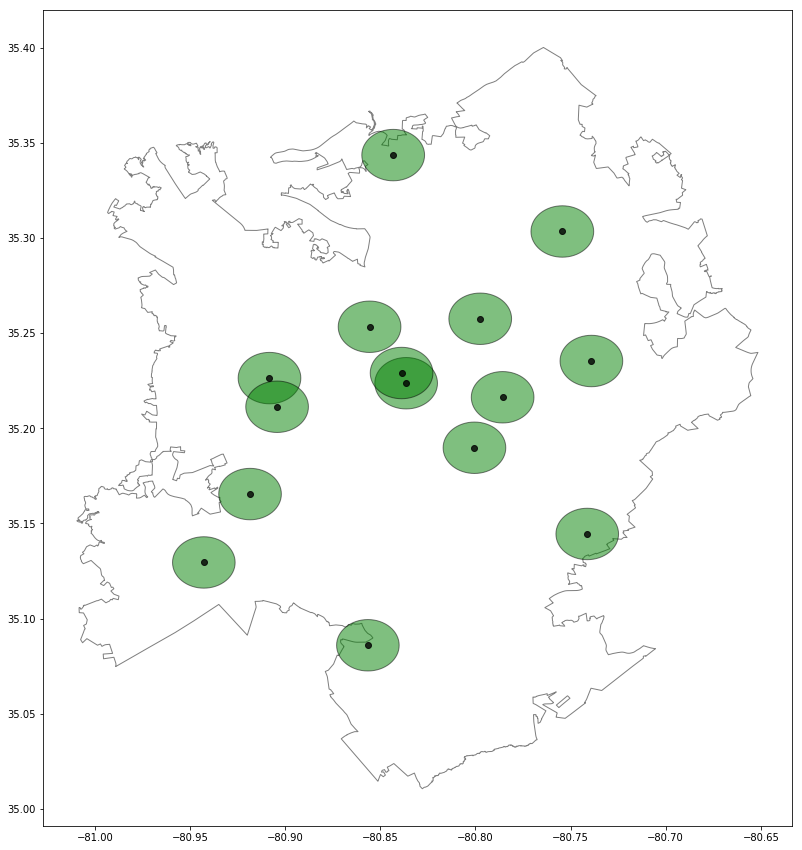

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.set_aspect('equal')

city.to_crs(util.crs.epsg4269).plot(ax=ax, color='none', edgecolor='black', alpha=0.5)
df1.to_crs(util.crs.epsg4269).plot(ax=ax, color='green', edgecolor='black', alpha=0.5)
df.to_crs(util.crs.epsg4269).plot(ax=ax, color='k', alpha=0.8);

This distortion is expected from EPSG:4269 projection. The distortions caused by the equal-area projection, however, are too small and can be considered negligible (for example, compare the following coordinates with the coordinates generated by the following notebook, which uses an exact approach).

In [21]:
df1.to_crs(util.crs.epsg4269).bounds

,minx,miny,maxx,maxy
0,-80.959273,35.115954,-80.926358,35.142995
1,-80.873021,35.072415,-80.840123,35.099456
2,-80.802210,35.202789,-80.769260,35.229830
3,-80.852933,35.210170,-80.819980,35.237210
4,-80.924777,35.212867,-80.891823,35.239907
5,-80.817018,35.176248,-80.784079,35.203289
6,-80.757716,35.130929,-80.724795,35.157970
7,-80.755552,35.221851,-80.722594,35.248892
8,-80.855336,35.215542,-80.822381,35.242582
9,-80.813999,35.244062,-80.781032,35.271102
